In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np 
import matplotlib.pyplot as plt
import random

import os
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import cv2
import string
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
dir = "/content/drive/MyDrive/captcha_images" 
n=len(os.listdir(dir))
n                                             

9960

In [ ]:
files_list = random.sample(os.listdir(dir), n)
files_list[:10]

['KCHN.png',
 '97YF.png',
 '39P8.png',
 'DDHS.png',
 'ZYEG.png',
 '9ZTF.png',
 '8NH2.png',
 'DH76.png',
 'BREH.png',
 'W2GZ.png']

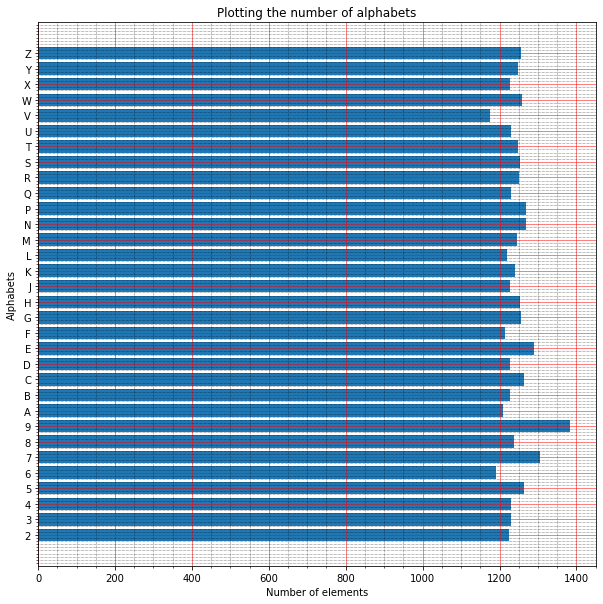

In [ ]:
labels = os.listdir(dir)
letter = {}
for label in labels:
  for unit in label[:4]:
    if unit in letter:
      letter[unit] += 1
    else:
      letter[unit] = 1

alphabets, values = zip(*sorted(letter.items()))
 
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.barh(alphabets, values)
plt.xlabel("Number of elements")
plt.ylabel("Alphabets")
plt.title("Plotting the number of alphabets")
plt.minorticks_on()

plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')

plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
imgshape=(24,72,1) 

In [ ]:
character= string.ascii_uppercase + "23456789" 
nchar = len(character)                         
nchar

34

In [ ]:
#preprocesss image
def preprocess():
  X = np.zeros((n,24,72,1))                                           
  y = np.zeros((4,n,nchar))                                           
  for i, pic in enumerate(random.sample(os.listdir(dir), n)):
    img = cv2.imread(os.path.join(dir, pic), cv2.IMREAD_GRAYSCALE)
    pic_target = pic[:-4]                                            
    
    if len(pic_target) < 5:                                           
      img = img / 255.0                                              
      img = np.reshape(img, (24, 72, 1))                              

      target=np.zeros((4,nchar))

      for j, k in enumerate(pic_target):
         index = character.find(k)                                    
         target[j, index] = 1                                         

      X[i] = img 
      y[:,i] = target 
  return X,y

In [ ]:
X,y=preprocess()

In [ ]:
X_train, y_train = X[:7467], y[:, :7467] 
X_test, y_test = X[7467:], y[:, 7467:]

In [ ]:
np.shape(X_train)

(7467, 24, 72, 1)

In [ ]:
np.shape(y_train)

(4, 7467, 34)

# **Model 1 (CNN with 24 layers)**



In [ ]:
def createmodel():
    img = layers.Input(shape=imgshape)
    conv1 = layers.Conv2D(16, 3, padding='same', activation='relu')(img)  
    mp1 = layers.MaxPooling2D(padding='same')(conv1)                      
    conv2 = layers.Conv2D(32, 3, padding='same', activation='relu')(mp1)  
    mp2 = layers.MaxPooling2D(padding='same')(conv2)
    conv3 = layers.Conv2D(32, 3, padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)                               
    mp3 = layers.MaxPooling2D(padding='same')(bn) 
    
    flat = layers.Flatten()(mp3)                                           

    outs = []
    for _ in range(4):                                                    
        dens1 = layers.Dense(64, activation='relu')(flat)                 
        drop = layers.Dropout(0.5)(dens1)                                 
        res = layers.Dense(nchar, activation='sigmoid')(drop)             

        outs.append(res) 

    model = Model(img, outs)                                            
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"]) 
    return model

In [ ]:
model=createmodel();
model.summary();

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 24, 72, 1)]  0           []                               
                                                                                                  
 conv2d_47 (Conv2D)             (None, 24, 72, 16)   160         ['input_16[0][0]']               
                                                                                                  
 max_pooling2d_46 (MaxPooling2D  (None, 12, 36, 16)  0           ['conv2d_47[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 12, 36, 32)   4640        ['max_pooling2d_46[0][0]']

In [ ]:
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3]], batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
187/187 [==============================] - 4s 12ms/step - loss: 14.0920 - dense_33_loss: 3.5172 - dense_35_loss: 3.5281 - dense_37_loss: 3.5264 - dense_39_loss: 3.5202 - dense_33_accuracy: 0.0343 - dense_35_accuracy: 0.0373 - dense_37_accuracy: 0.0338 - dense_39_accuracy: 0.0365 - val_loss: 14.0456 - val_dense_33_loss: 3.5091 - val_dense_35_loss: 3.5152 - val_dense_37_loss: 3.5085 - val_dense_39_loss: 3.5128 - val_dense_33_accuracy: 0.0428 - val_dense_35_accuracy: 0.0315 - val_dense_37_accuracy: 0.0221 - val_dense_39_accuracy: 0.0388
Epoch 2/20
187/187 [==============================] - 2s 11ms/step - loss: 13.0524 - dense_33_loss: 3.1706 - dense_35_loss: 3.3290 - dense_37_loss: 3.2779 - dense_39_loss: 3.2750 - dense_33_accuracy: 0.1080 - dense_35_accuracy: 0.0790 - dense_37_accuracy: 0.0887 - dense_39_accuracy: 0.0859 - val_loss: 12.1514 - val_dense_33_loss: 2.9069 - val_dense_35_loss: 3.1348 - val_dense_37_loss: 3.0374 - val_dense_39_loss: 3.0722 - val_dense_33_accuracy: 0

### Testing and Performance Graphs

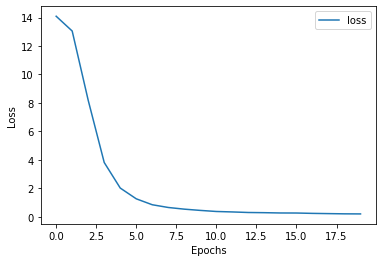

In [ ]:
#graph of loss vs epochs
for label in ["loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
for label in ["val_dense_9_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_11_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_13_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_15_accuracy"]:
  plt.plot(hist.history[label],label=label)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

KeyError: ignored

In [ ]:
#Loss on training set
preds = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3]])
print ("Loss on training set= " + str(preds[0]))

234/234 [==============================] - 1s 6ms/step - loss: 0.0036 - dense_33_loss: 1.9941e-04 - dense_35_loss: 0.0011 - dense_37_loss: 6.4508e-04 - dense_39_loss: 0.0017 - dense_33_accuracy: 0.9997 - dense_35_accuracy: 0.9995 - dense_37_accuracy: 0.9997 - dense_39_accuracy: 0.9995
Loss on training set= 0.003633372252807021


In [ ]:
#Finding loss on test set
preds = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3]])
print ("Loss on testing set= " + str(preds[0]))

78/78 [==============================] - 0s 6ms/step - loss: 0.0236 - dense_33_loss: 0.0019 - dense_35_loss: 0.0072 - dense_37_loss: 0.0080 - dense_39_loss: 0.0064 - dense_33_accuracy: 0.9984 - dense_35_accuracy: 0.9964 - dense_37_accuracy: 0.9968 - dense_39_accuracy: 0.9968
Loss on testing set= 0.023581422865390778


In [ ]:
from matplotlib.spines import allow_rasterization
#to predict captcha
def predict(filepath):                                                
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)                  

    if img is not None: 
        img = img / 255.0                                             
    else:
        print("Not detected");

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))  
    result = np.reshape(res, (4, 34)) 
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i))                                    

    capt = ''
    for k in k_ind:                                                   
        capt += character[k] 
    return capt 

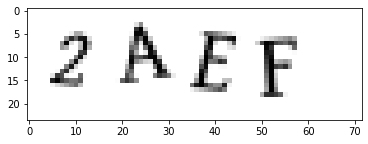

In [ ]:
#Sample 1
img=cv2.imread("/content/drive/MyDrive/captcha_images/2AEF.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
print("Predicted Captcha =",predict("/content/drive/MyDrive/captcha_images/2AEF.png"))

Predicted Captcha = 2AEF


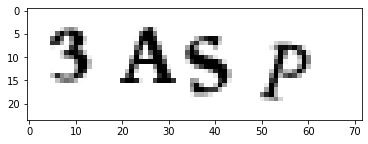

In [ ]:
#Sample 2
img=cv2.imread("/content/drive/MyDrive/captcha_images/3ASP.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
print("Predicted Captcha =",predict("/content/drive/MyDrive/captcha_images/3ASP.png"))

Predicted Captcha = 3ASP


# **MODEL 2 (RECURRENT NEURAL NETWORK)**

In [ ]:
char_list= list(alphabets)
max_label_len = 4
"".join(char_list)

'23456789ABCDEFGHJKLMNPQRSTUVWXYZ'

In [ ]:

def encode_to_labels(txt):
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(alphabets.index(char))
        except:
            print("No found in char_list :", char)
    return dig_lst
    
encode_to_labels("2345ABCDE") 

[0, 1, 2, 3, 8, 9, 10, 11, 12]

In [ ]:
import glob
all_image_paths = glob.glob(os.path.join(dir, "*.png"))
all_image_paths = random.sample(all_image_paths, len(all_image_paths))
all_image_paths[:5]

['/content/drive/MyDrive/captcha_images/2YUF.png',
 '/content/drive/MyDrive/captcha_images/5XF6.png',
 '/content/drive/MyDrive/captcha_images/ASVF.png',
 '/content/drive/MyDrive/captcha_images/QBFW.png',
 '/content/drive/MyDrive/captcha_images/G9PJ.png']

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.2
train_image_paths, test_image_paths = train_test_split(all_image_paths, test_size=test_size, random_state=42)

In [ ]:
TIME_STEPS = 9
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

for train_img_path in train_image_paths:
    img = cv2.cvtColor(cv2.imread(train_img_path), cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    label = train_img_path[-8:-4]
    orig_txt.append(label)   
    train_label_length.append(len(label))
    train_input_length.append(TIME_STEPS)
    training_img.append(img)
    training_txt.append(encode_to_labels(label)) 

No found in char_list :  
No found in char_list : (
No found in char_list : 1
No found in char_list : )
No found in char_list :  
No found in char_list : (
No found in char_list : 1
No found in char_list : )
No found in char_list :  
No found in char_list : (
No found in char_list : 1
No found in char_list : )
No found in char_list :  
No found in char_list : (
No found in char_list : 1
No found in char_list : )
No found in char_list :  
No found in char_list : (
No found in char_list : 1
No found in char_list : )


In [ ]:
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

for test_img_path in test_image_paths:
    img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    label = test_img_path[-8:-4]
    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))
    valid_input_length.append(TIME_STEPS)
    valid_img.append(img)
    valid_txt.append(encode_to_labels(label))

In [ ]:
max_label_len = TIME_STEPS
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

In [ ]:
#MODEL OF CRNN AND LSTM

inputs = Input(shape=(24,72,1))
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)
batch_norm_3 = BatchNormalization()(pool_3)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(batch_norm_3)
batch_norm_5 = BatchNormalization()(conv_4)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(3, 1))(batch_norm_6)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_6)
 
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 24, 72, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 72, 64)        640       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 12, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 36, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 18, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 6, 18, 256)        2951

# **MODEL (3) : CONNECTIONIST TEMPORAL CLASSIFICATION**


In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
#using tensorboard to create a log file for the model
callbacks = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"),
    ModelCheckpoint(
        filepath='checkpoint_weights.hdf5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=15,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 24, 72, 1)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 24, 72, 64)   640         ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 12, 36, 64)  0           ['conv2d_15[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 12, 36, 128)  73856       ['max_pooling2d_15[0][0]'] 

In [ ]:
# training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  
train_label_length = np.array(train_label_length)  

# test data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) 
valid_label_length = np.array(valid_label_length) 

In [ ]:
batch_size = 32
epochs = 10

history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callbacks_list)

Epoch 1/10
249/249 [==============================] - ETA: 0s - loss: 4.4901
Epoch 1: val_loss improved from inf to 24.14106, saving model to checkpoint_weights.hdf5
249/249 [==============================] - 23s 49ms/step - loss: 4.4901 - val_loss: 24.1411 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - ETA: 0s - loss: 0.1401
Epoch 2: val_loss improved from 24.14106 to 4.88612, saving model to checkpoint_weights.hdf5
249/249 [==============================] - 8s 33ms/step - loss: 0.1401 - val_loss: 4.8861 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - ETA: 0s - loss: 0.1073
Epoch 3: val_loss improved from 4.88612 to 4.77564, saving model to checkpoint_weights.hdf5
249/249 [==============================] - 15s 62ms/step - loss: 0.1073 - val_loss: 4.7756 - lr: 0.0010
Epoch 4/10
248/249 [============================>.] - ETA: 0s - loss: 0.0733
Epoch 4: val_loss improved from 4.77564 to 4.16835, saving model to checkpoint_weights.hdf5
249/249 [=====

In [ ]:
NO_PREDICTS = 200
OFFSET=0
prediction = act_model.predict(valid_img[OFFSET:OFFSET+NO_PREDICTS])

In [ ]:
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
all_predictions =[]
i = 0
for x in out:
    pred = ""
    for p in x:  
        if int(p) != -1:
            pred += char_list[int(p)]
    all_predictions.append(pred)
    i+=1

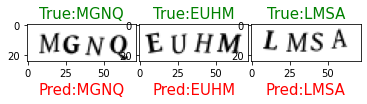

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10,100))
col=0
row=1
gs1 = gridspec.GridSpec(NO_PREDICTS//5, 5)
gs1.update(wspace=0.025, hspace=0.025)
for n in range(3):
    plt.subplot(gs1[n])
    plt.title("True:"+valid_orig_txt[n+OFFSET], fontsize=15, color="green")
    plt.imshow(valid_img[n][:,:,0], cmap="gray")
    plt.xlabel("Pred:"+all_predictions[n+OFFSET], fontsize=15, color="red")

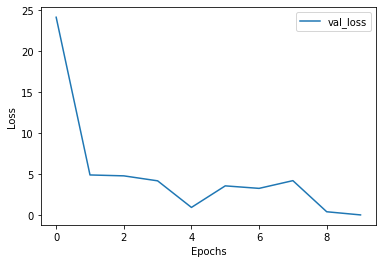

In [ ]:
#loss vs epochs
for label in ["val_loss"]:
  plt.plot(history.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()